In [2]:
# Install openvino package
%pip install -q "openvino>=2024.4.0" pillow opencv-python "matplotlib>=3.4"

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import load_image, device_widget

In [4]:
core = ov.Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-0014"

model_dir.mkdir(exist_ok=True)

In [5]:
from notebook_utils import download_ir_model

detection_model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{detection_model}/{precision}/{detection_model}.xml"

recognition_model_url = (
    f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{recognition_model}/{precision}/{recognition_model}.xml"
)

detection_model_path = download_ir_model(detection_model_url, model_dir / detection_model / precision)

recognition_model_path = download_ir_model(recognition_model_url, model_dir / recognition_model / precision)

'model/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml' already exists.
'model/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.bin' already exists.
'model/text-recognition-0014/FP16/text-recognition-0014.xml' already exists.
'model/text-recognition-0014/FP16/text-recognition-0014.bin' already exists.


In [6]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [7]:
detection_model = core.read_model(detection_model_path)
detection_compiled_model = core.compile_model(model=detection_model, device_name=device.value)

detection_input_layer = detection_compiled_model.input(0)

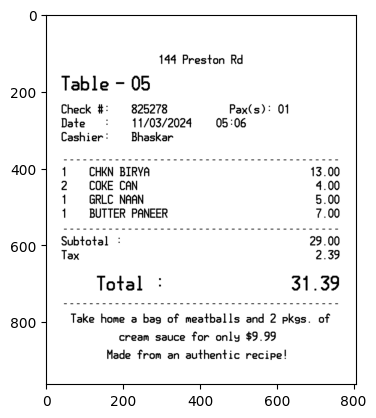

In [8]:
# The `image_file` variable can point to a URL or a local image.
image_file = "rec4.png"

image = load_image(image_file)

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = detection_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [9]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [10]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x for idx, shape in enumerate(box[:-1])]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1)
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

In [11]:
recognition_model = core.read_model(recognition_model_path)

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

In [12]:
# Calculate scale for image resizing.
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert the image to grayscale for the text recognition model.
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a dictionary to encode output, based on the model documentation.
letters = "#1234567890abcdefghijklmnopqrstuvwxyz"

# Prepare an empty list for annotations.
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# Get annotations for each crop, based on boxes given by the detection model.
for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            continue
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

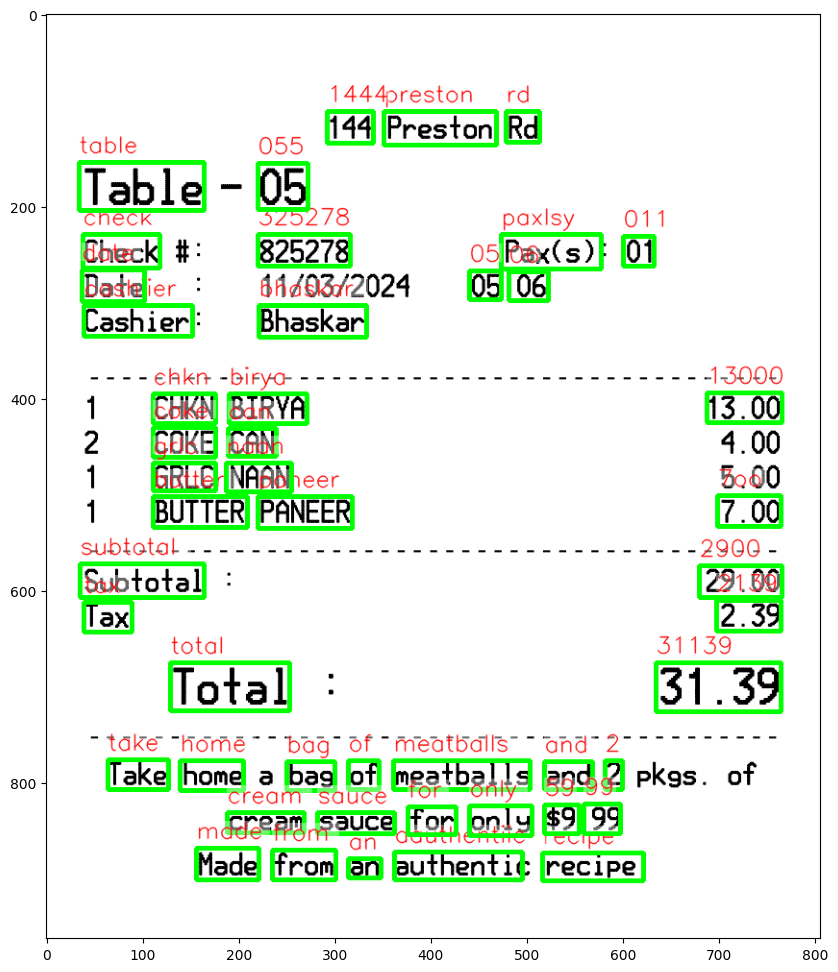

In [13]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True));

birya

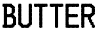

butter

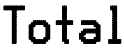

total

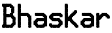

bhaskar

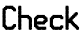

check

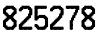

325278

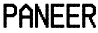

paneer

chkn

recipe

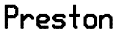

preston

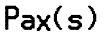

paxlsy

home

and

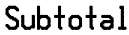

subtotal

of

bag

take

can

coke

an

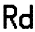

rd

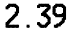

2139

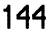

1444

011

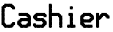

cashiier

grlc

aauthentiic

sauce

meatballs

cream

naan

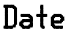

date

2

99

only

59

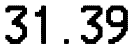

31139

tax

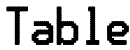

table

06

for

from

13000

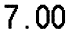

7oo

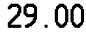

2900

05

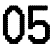

055

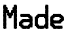

made

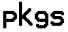

pkgs

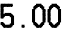

50

of

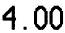

4000

p

In [14]:
for cropped_image, annotation in zip(cropped_images, annotations):
    display(cropped_image, Markdown("".join(annotation)))

In [15]:
[annotation for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)]

['table',
 'check',
 'date',
 'p',
 '055',
 'cashiier',
 '325278',
 '1444',
 'bhaskar',
 'chkn',
 'preston',
 'coke',
 'birya',
 'grlc',
 'can',
 'naan',
 'butter',
 'paneer',
 'subtotal',
 'rd',
 '05',
 'paxlsy',
 'tax',
 '06',
 'total',
 '011',
 'take',
 'home',
 'bag',
 'cream',
 'of',
 'made',
 'meatballs',
 'sauce',
 '13000',
 'from',
 '4000',
 'for',
 'an',
 '50',
 '7oo',
 'aauthentiic',
 'only',
 '2900',
 'and',
 '31139',
 '59',
 '2139',
 '2',
 '99',
 'pkgs',
 'recipe',
 'of']

In [16]:
import re

# Sorting bounding boxes by top-to-bottom, then left-to-right within each row
boxes_sorted = sorted(boxes, key=lambda b: (b[1], b[0]))  # Sort by (y_min, x_min)

# Group boxes by rows, assuming y-axis closeness means they're in the same row
row_threshold = 30  # Adjust as needed based on image scale
rows = []
current_row = []

for i, box in enumerate(boxes_sorted):
    if not current_row or abs(current_row[-1][1] - box[1]) < row_threshold:
        current_row.append(box)
    else:
        rows.append(current_row)
        current_row = [box]
rows.append(current_row)  # Add the last row

parsed_data = []

# OCR and parse each row
for row in rows:
    row_text = ""
    # Sort row boxes by x_min to get left-to-right order
    row = sorted(row, key=lambda b: b[0])

    for box in row:
        x_min, y_min, x_max, y_max = map(int, multiply_by_ratio(ratio_x, ratio_y, box))
        crop = grayscale_image[y_min:y_max, x_min:x_max]
        processed_crop = run_preprocesing_on_crop(crop, (W, H))
        result = recognition_compiled_model([processed_crop])[recognition_output_layer]
        
        recognition_results = np.squeeze(result)
        
        annotation = "".join(
            letters[letter.argmax()] for letter in recognition_results if letters[letter.argmax()] != "#"
        )
        row_text += f"{annotation} "
    
    # Use multiple regex patterns to try and match ID, item, and price
    row_text = row_text.strip()
    print(f"\nRow Text: '{row_text}'")  # Debug print each row’s OCR text

    # Try common patterns
    match = re.match(r"(\d+)\s+([A-Za-z ]+)\s+(\d+(\.\d{2})?)", row_text)  # Basic ID-item-price pattern
    if match:
        ID, item, price = match.groups()[:3]
        parsed_data.append({"ID": ID, "Item": item, "Price": price})
    else:
        # Additional regex attempts for other patterns
        match_alt = re.match(r"([A-Za-z ]+)\s+(\d+(\.\d{2})?)", row_text)  # Try item-price only pattern
        if match_alt:
            item, price = match_alt.groups()[:2]
            parsed_data.append({"ID": None, "Item": item, "Price": price})
        else:
            print("Regex did not match for this row.")

# Final output
print("\nParsed Data:")
for entry in parsed_data:
    print(f"ID: {entry['ID']}, Item: {entry['Item']}, Price: {entry['Price']}")



Row Text: '1444 preston rd'
Regex did not match for this row.

Row Text: 'table 055'

Row Text: 'date check cashiier p 325278 bhaskar 05 paxlsy 06 011'

Row Text: 'butter grlc coke chkn naan can birya paneer 13000 7oo 4000 50'

Row Text: 'subtotal tax 2900 2139'

Row Text: 'total 31139'

Row Text: 'take home bag of meatballs and 2 pkgs of'

Row Text: 'made cream from sauce an aauthentiic for only recipe 59 99'

Parsed Data:
ID: None, Item: table, Price: 055
ID: None, Item: date check cashiier p, Price: 325278
ID: None, Item: butter grlc coke chkn naan can birya paneer, Price: 13000
ID: None, Item: subtotal tax, Price: 2900
ID: None, Item: total, Price: 31139
ID: None, Item: take home bag of meatballs and, Price: 2
ID: None, Item: made cream from sauce an aauthentiic for only recipe, Price: 59


In [17]:
# NEW MODEL

In [19]:
%pip install easyocr

import easyocr
import cv2
import re
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 96.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 111.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
def preprocess_image(image_path):
    # Load and preprocess the image for better OCR accuracy
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    return image

def clean_text(text):
    # Replace common OCR errors
    text = text.replace("o0", "00").replace("O0", "00").replace("_.", ".").replace("_", ".")
    return text

In [29]:
### NEWER MODEL

In [30]:
def preprocess_image(image_path):
    # Load and preprocess the image for better OCR accuracy
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    return image

def clean_text(text):
    # Replace common OCR errors
    text = text.replace("o0", "00").replace("O0", "00").replace("_.", ".").replace("_", ".")
    return text


In [31]:
def parse_receipt_data(text_data):
    parsed_data = []
    skip_patterns = [r"^Table", r"^Check", r"^Date", r"^Total", r"^Tax", r"^Subtotal", r"Cashier", r"^Pax", r"^\d{2}:\d{2}"]

    i = 0
    while i < len(text_data):
        line = clean_text(text_data[i]).strip()

        # Skip irrelevant lines
        if any(re.match(pattern, line) for pattern in skip_patterns):
            i += 1
            continue

        # Match line with item and price across two lines
        if re.match(r"([A-Za-z\s]+)", line) and i + 1 < len(text_data) and re.match(r"\d+\.\d{2}", clean_text(text_data[i + 1]).strip()):
            item = line.strip()
            price = clean_text(text_data[i + 1]).strip()
            parsed_data.append(f"1 {item} {price}")
            i += 2
            continue

        # Match line with quantity, item, and price in one line
        match = re.match(r"(\d+)?\s*([A-Za-z\s]+)\s(\d+\.\d{2})", line)
        if match:
            quantity = match.group(1) if match.group(1) else "1"  # Default quantity to 1 if missing
            item = match.group(2).strip()
            price = match.group(3)
            parsed_data.append(f"{quantity} {item} {price}")
        # Skip unrecognized lines without printing them
        i += 1

    return parsed_data

In [33]:
def process_receipt(image_path):
    reader = easyocr.Reader(['en'])
    image = preprocess_image(image_path)
    results = reader.readtext(image)

    print("Parsed Data:")
    recognized_text = [text for (_, text, _) in results]

    parsed_data = parse_receipt_data(recognized_text)
    
    # Make sure that it isnt the unrecognized lines.. we gotta make sure it's teh menu items only
    for line in parsed_data:
        print(line)

process_receipt('rec5.png')


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Parsed Data:
1 TaCO 12.00
1 CHEES QUESAD 8.00
1 ORNG JARRITO 4.00
1 DIP 8.00


In [35]:
process_receipt('rec4.png')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Parsed Data:
1 CHKN BIRYA 13.00
1 COKE CAN 4.00
1 GRLC NAAn 5.00
